# Predictive Maintenance using Machine Learning on Sagemaker
*Part 3 - Timeseries data preparation*

## Initialization
---
Directory structure to run this notebook:
```
nasa-turbofan-rul-lstm
|
+--- data
|   |
|   +--- interim: intermediate data we can manipulate and process
|   |
|   \--- raw: *immutable* data downloaded from the source website
|
+--- notebooks: all the notebooks are positionned here
|
+--- src: utility python modules are stored here
```
### Imports

In [1]:
%load_ext autoreload

import matplotlib.pyplot as plt
import sagemaker
import boto3
import os
import errno
import pandas as pd
import numpy as np
import seaborn as sns
import json
import sys
import s3fs
import mxnet as mx
import joblib

In [2]:
%matplotlib inline
%autoreload 2

sns.set_style('darkgrid')
sys.path.append('../src')

figures = []

INTERIM_DATA = '../data/interim'
PROCESSED_DATA = '../data/processed'

### Loading data from the previous notebook

In [3]:
# Load data from the notebook local storage:
%store -r reduced_train_data
%store -r reduced_test_data

# If the data are not present in the notebook local storage, we need to load them from disk:
success_msg = 'Loaded "reduced_train_data"'
if 'reduced_train_data' not in locals():
    print('Nothing in notebook store, trying to load from disk.')
    try:
        local_path = '../data/interim'
        reduced_train_data = pd.read_csv(os.path.join(local_path, 'reduced_train_data.csv'))
        reduced_train_data = reduced_train_data.set_index(['unit_number', 'time'])
            
        print(success_msg)
            
    except Exception as e:
        if (e.errno == errno.ENOENT):
            print('Files not found to load train data from: you need to execute the previous notebook.')
            
else:
    print('Train data found in notebook environment.')
    print(success_msg)
    
success_msg = 'Loaded "reduced_test_data"'
if 'reduced_test_data' not in locals():
    print('Nothing in notebook store, trying to load from disk.')
    try:
        local_path = '../data/interim'
        reduced_test_data = pd.read_csv(os.path.join(local_path, 'reduced_test_data.csv'))
        reduced_test_data = reduced_test_data.set_index(['unit_number', 'time'])
            
        print(success_msg)
            
    except Exception as e:
        if (e.errno == errno.ENOENT):
            print('Files not found to load test data from: you need to execute the previous notebook.')
            
else:
    print('Test data found in notebook environment.')
    print(success_msg)

no stored variable reduced_train_data
no stored variable reduced_test_data
Nothing in notebook store, trying to load from disk.
Loaded "reduced_train_data"
Nothing in notebook store, trying to load from disk.
Loaded "reduced_test_data"


In [4]:
print(reduced_train_data.shape)
reduced_train_data.head()

(20631, 19)


true_rul  piecewise_rul  operational_setting_1  \
unit_number time                                                   
1           1          191            130                -0.0007   
            2          190            130                 0.0019   
            3          189            130                -0.0043   
            4          188            130                 0.0007   
            5          187            130                -0.0019   

                  operational_setting_2  sensor_measurement_2  \
unit_number time                                                
1           1                   -0.0004                641.82   
            2                   -0.0003                642.15   
            3                    0.0003                642.35   
            4                    0.0000                642.35   
            5                   -0.0002                642.37   

                  sensor_measurement_3  sensor_measurement_4  \
unit_number time                                               
1           1                  1589.70               1400.60   
            2                  1591.82               1403.14   
            3                  1587.99               1404.20   
            4                  1582.79               1401.87   
            5                  1582.85               1406.22   

                  sensor_measurement_6  sensor_measurement_7  \
unit_number time                                               
1           1                    21.61                554.36   
            2                    21.61                553.75   
            3                    21.61                554.26   
            4                    21.61                554.45   
            5                    21.61                554.00   

                  sensor_measurement_8  sensor_measurement_9  \
unit_number time                                               
1           1                  2388.06               9046.19   
            2                  2388.04               9044.07   
            3                  2388.08               9052.94   
            4                  2388.11               9049.48   
            5                  2388.06               9055.15   

                  sensor_measurement_11  sensor_measurement_12  \
unit_number time                                                 
1           1                     47.47                 521.66   
            2                     47.49                 522.28   
            3                     47.27                 522.42   
            4                     47.13                 522.86   
            5                     47.28                 522.19   

                  sensor_measurement_13  sensor_measurement_14  \
unit_number time                                                 
1           1                   2388.02                8138.62   
            2                   2388.07                8131.49   
            3                   2388.03                8133.23   
            4                   2388.08                8133.83   
            5                   2388.04                8133.80   

                  sensor_measurement_15  sensor_measurement_17  \
unit_number time                                                 
1           1                    8.4195                    392   
            2                    8.4318                    392   
            3                    8.4178                    390   
            4                    8.3682                    392   
            5                    8.4294                    393   

                  sensor_measurement_20  sensor_measurement_21  
unit_number time                                                
1           1                     39.06                23.4190  
            2                     39.00                23.4236  
            3                     38.95                23.3442  
            4           

In [5]:
print(reduced_test_data.shape)
reduced_test_data.head()

(13096, 26)


true_rul  piecewise_rul  operational_setting_1  \
unit_number time                                                   
1           1          142            130                 0.0023   
            2          141            130                -0.0027   
            3          140            130                 0.0003   
            4          139            130                 0.0042   
            5          138            130                 0.0014   

                  operational_setting_2  operational_setting_3  \
unit_number time                                                 
1           1                    0.0003                  100.0   
            2                   -0.0003                  100.0   
            3                    0.0001                  100.0   
            4                    0.0000                  100.0   
            5                    0.0000                  100.0   

                  sensor_measurement_1  sensor_measurement_2  \
unit_number time                                               
1           1                   518.67                643.02   
            2                   518.67                641.71   
            3                   518.67                642.46   
            4                   518.67                642.44   
            5                   518.67                642.51   

                  sensor_measurement_3  sensor_measurement_4  \
unit_number time                                               
1           1                  1585.29               1398.21   
            2                  1588.45               1395.42   
            3                  1586.94               1401.34   
            4                  1584.12               1406.42   
            5                  1587.19               1401.92   

                  sensor_measurement_5  ...  sensor_measurement_12  \
unit_number time                        ...                          
1           1                    14.62  ...                 521.72   
            2                    14.62  ...                 522.16   
            3                    14.62  ...                 521.97   
            4                    14.62  ...                 521.38   
            5                    14.62  ...                 522.15   

                  sensor_measurement_13  sensor_measurement_14  \
unit_number time                                                 
1           1                   2388.03                8125.55   
            2                   2388.06                8139.62   
            3                   2388.03                8130.10   
            4                   2388.05                8132.90   
            5                   2388.03                8129.54   

                  sensor_measurement_15  sensor_measurement_16  \
unit_number time                                                 
1           1                    8.4052                   0.03   
            2                    8.3803                   0.03   
            3                    8.4441                   0.03   
            4                    8.3917                   0.03   
            5                    8.4031                   0.03   

                  sensor_measurement_17  sensor_measurement_18  \
unit_number time                                                 
1           1                       392                   2388   
            2                       393                   2388   
            3                       393                   2388   
            4                       391                   2388   
            5                       390                   2388   

                  sensor_measurement_19  sensor_measurement_20  \
unit_number time                                                 
1           1                     100.0                  38.86   
            2                     100.0                  39.02   
            3                     10

### Study parameters

In [6]:
sequence_length = 20

## Normalization
---
### Normalizing the training data
First, we build some scalers based on the training data:

In [7]:
from sklearn import preprocessing

# Isolate the columns to normalize:
normalized_cols = reduced_train_data.columns.difference(['true_rul', 'piecewise_rul'])

# Build MinMax scalers for the features and the labels:
features_scaler = preprocessing.MinMaxScaler()
labels_scaler = preprocessing.MinMaxScaler()

# Normalize the operational settings and sensor measurements data (our features):
reduced_train_data['sensor_measurement_17'] = reduced_train_data['sensor_measurement_17'].astype(np.float64)
normalized_data = pd.DataFrame(
    features_scaler.fit_transform(reduced_train_data[normalized_cols]),
    columns=normalized_cols, 
    index=reduced_train_data.index
)

# Normalizing the labels data:
reduced_train_data['piecewise_rul'] = reduced_train_data['piecewise_rul'].astype(np.float64)
normalized_training_labels = pd.DataFrame(
    labels_scaler.fit_transform(reduced_train_data[['piecewise_rul']]),
    columns=['piecewise_rul'], 
    index=reduced_train_data.index
)

# Join the normalized features with the RUL (label) data:
joined_data = normalized_training_labels.join(normalized_data)
normalized_train_data = joined_data.reindex(columns=reduced_train_data.columns)
normalized_train_data['true_rul'] = reduced_train_data['true_rul']
print(normalized_train_data.shape)
normalized_train_data.head()

(20631, 19)


true_rul  piecewise_rul  operational_setting_1  \
unit_number time                                                   
1           1          191            1.0               0.459770   
            2          190            1.0               0.609195   
            3          189            1.0               0.252874   
            4          188            1.0               0.540230   
            5          187            1.0               0.390805   

                  operational_setting_2  sensor_measurement_2  \
unit_number time                                                
1           1                  0.166667              0.183735   
            2                  0.250000              0.283133   
            3                  0.750000              0.343373   
            4                  0.500000              0.343373   
            5                  0.333333              0.349398   

                  sensor_measurement_3  sensor_measurement_4  \
unit_number time                                               
1           1                 0.406802              0.309757   
            2                 0.453019              0.352633   
            3                 0.369523              0.370527   
            4                 0.256159              0.331195   
            5                 0.257467              0.404625   

                  sensor_measurement_6  sensor_measurement_7  \
unit_number time                                               
1           1                      1.0              0.726248   
            2                      1.0              0.628019   
            3                      1.0              0.710145   
            4                      1.0              0.740741   
            5                      1.0              0.668277   

                  sensor_measurement_8  sensor_measurement_9  \
unit_number time                                               
1           1                 0.242424              0.109755   
            2                 0.212121              0.100242   
            3                 0.272727              0.140043   
            4                 0.318182              0.124518   
            5                 0.242424              0.149960   

                  sensor_measurement_11  sensor_measurement_12  \
unit_number time                                                 
1           1                  0.369048               0.633262   
            2                  0.380952               0.765458   
            3                  0.250000               0.795309   
            4                  0.166667               0.889126   
            5                  0.255952               0.746269   

                  sensor_measurement_13  sensor_measurement_14  \
unit_number time                                                 
1           1                  0.205882               0.199608   
            2                  0.279412               0.162813   
            3                  0.220588               0.171793   
            4                  0.294118               0.174889   
            5                  0.235294               0.174734   

                  sensor_measurement_15  sensor_measurement_17  \
unit_number time                                                 
1           1                  0.363986               0.333333   
            2                  0.411312               0.333333   
            3                  0.357445               0.166667   
            4                  0.166603               0.333333   
            5                  0.402078               0.416667   

                  sensor_measurement_20  sensor_measurement_21  
unit_number time                                                
1           1                  0.713178               0.724662  
            2                  0.666667               0.731014  
            3                  0.627907               0.621375  
            4           

### Normalizing the testing data
Next, we apply these normalizers to the testing data:

In [8]:
normalized_test_data = pd.DataFrame(
    features_scaler.transform(reduced_test_data[normalized_cols]),
    columns=normalized_cols,
    index=reduced_test_data.index
)

reduced_test_data['piecewise_rul'] = reduced_test_data['piecewise_rul'].astype(np.float64)

normalized_test_labels = pd.DataFrame(
    labels_scaler.transform(reduced_test_data[['piecewise_rul']]),
    columns=['piecewise_rul'], 
    index=reduced_test_data.index
)

# Join the normalize data with the RUL data:
joined_data = normalized_test_labels.join(normalized_test_data)
normalized_test_data = joined_data.reindex(columns=reduced_test_data.columns)
normalized_test_data['true_rul'] = reduced_test_data['true_rul']
print(normalized_test_data.shape)
normalized_test_data.head()

(13096, 26)


true_rul  piecewise_rul  operational_setting_1  \
unit_number time                                                   
1           1          142            1.0               0.632184   
            2          141            1.0               0.344828   
            3          140            1.0               0.517241   
            4          139            1.0               0.741379   
            5          138            1.0               0.580460   

                  operational_setting_2  operational_setting_3  \
unit_number time                                                 
1           1                  0.750000                    NaN   
            2                  0.250000                    NaN   
            3                  0.583333                    NaN   
            4                  0.500000                    NaN   
            5                  0.500000                    NaN   

                  sensor_measurement_1  sensor_measurement_2  \
unit_number time                                               
1           1                      NaN              0.545181   
            2                      NaN              0.150602   
            3                      NaN              0.376506   
            4                      NaN              0.370482   
            5                      NaN              0.391566   

                  sensor_measurement_3  sensor_measurement_4  \
unit_number time                                               
1           1                 0.310661              0.269413   
            2                 0.379551              0.222316   
            3                 0.346632              0.322248   
            4                 0.285154              0.408001   
            5                 0.352082              0.332039   

                  sensor_measurement_5  ...  sensor_measurement_12  \
unit_number time                        ...                          
1           1                      NaN  ...               0.646055   
            2                      NaN  ...               0.739872   
            3                      NaN  ...               0.699360   
            4                      NaN  ...               0.573561   
            5                      NaN  ...               0.737740   

                  sensor_measurement_13  sensor_measurement_14  \
unit_number time                                                 
1           1                  0.220588               0.132160   
            2                  0.264706               0.204768   
            3                  0.220588               0.155640   
            4                  0.250000               0.170090   
            5                  0.220588               0.152751   

                  sensor_measurement_15  sensor_measurement_16  \
unit_number time                                                 
1           1                  0.308965                    NaN   
            2                  0.213159                    NaN   
            3                  0.458638                    NaN   
            4                  0.257022                    NaN   
            5                  0.300885                    NaN   

                  sensor_measurement_17  sensor_measurement_18  \
unit_number time                                                 
1           1                  0.333333                    NaN   
            2                  0.416667                    NaN   
            3                  0.416667                    NaN   
            4                  0.250000                    NaN   
            5                  0.166667                    NaN   

                  sensor_measurement_19  sensor_measurement_20  \
unit_number time                                                 
1           1                       NaN               0.558140   
            2                       NaN               0.682171   
            3                       

## Sequences generation
---

In [9]:
from lstm_utils import generate_sequences, generate_labels, generate_training_sequences, generate_testing_sequences

# Building features, target and engine unit lists:
features = normalized_train_data.columns.difference(['true_rul', 'piecewise_rul'])
target = ['piecewise_rul']
unit_list = list(set(normalized_train_data.index.get_level_values(level=0).tolist()))

# Generating features and labels for the training sequences:
train_sequences = generate_training_sequences(normalized_train_data, sequence_length, features, unit_list)
train_labels = generate_training_sequences(normalized_train_data, sequence_length, target, unit_list)
test_sequences, test_labels, unit_span = generate_testing_sequences(normalized_test_data, sequence_length, features, target, unit_list)

# Checking sequences shapes:
print('train_sequences:', train_sequences.shape)
print('train_labels:', train_labels.shape)
print('test_sequences:', test_sequences.shape)
print('test_labels:', test_labels.shape)

Unit 1 test sequence ignored, not enough data points.
Unit 22 test sequence ignored, not enough data points.
Unit 39 test sequence ignored, not enough data points.
Unit 85 test sequence ignored, not enough data points.
train_sequences: (18631, 20, 17)
train_labels: (18631, 1)
test_sequences: (11035, 20, 17)
test_labels: (11035, 1)


### Visualizing the sequences
Let's visualize the sequences we built for an engine (e.g. unit 3 in the example below) to understand what will be fed to the LSTM model:

Sequences generated for unit 1:



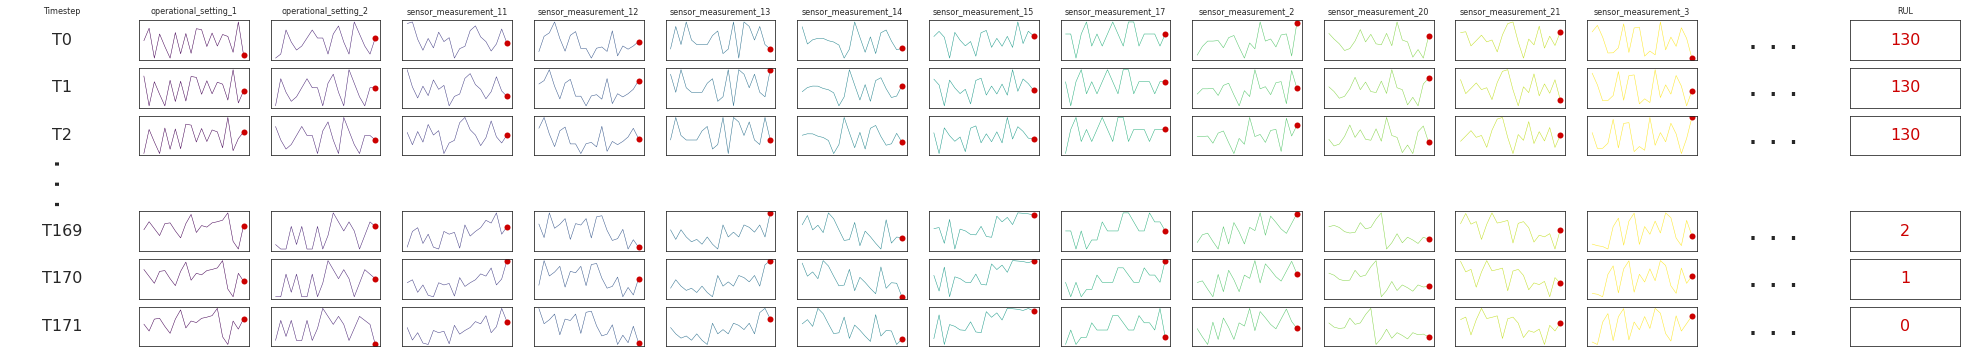

In [10]:
from lstm_utils import plot_timestep, plot_text

# We use the normalized sequences for the plot but the original data for the label (RUL) for understanding purpose:
current_unit = 1
tmp_sequences = generate_training_sequences(normalized_train_data, sequence_length, features, [current_unit])
tmp_labels = generate_training_sequences(reduced_train_data, sequence_length, target, [current_unit])

# Initialize the graphics:
print('Sequences generated for unit {}:\n'.format(current_unit))
sns.set_style('white')
fig = plt.figure(figsize=(35,6))

# Initialize the loop:
nb_signals = min(12, len(tmp_sequences[0][0]))
plots_per_row = nb_signals + 3
nb_rows = 7
nb_cols = plots_per_row
current_row = 0
previous_index = -1
timesteps = [
    # We will plot the first 3 sequences (first timesteps fed to the LSTM model):
    0, 1, 2, 

    # And the last 3 ones:
    len(tmp_sequences) - 3, len(tmp_sequences) - 2, len(tmp_sequences) - 1
]

# Loops through all the timesteps we want to plot:
for i in timesteps:
    # We draw a vertical ellispsis for the hole in the timesteps:
    if (i - previous_index > 1):
        plot_text(fig, nb_rows, nb_cols, nb_signals, current_row, '. . .', 1, no_axis=True, main_title='', plots_per_row=plots_per_row, options={'fontsize': 32, 'rotation': 270})
        current_row += 1

    # Timestep column:
    previous_index = i
    plot_text(fig, nb_rows, nb_cols, nb_signals, current_row, 'T{}'.format(i), 1, no_axis=True, main_title='Timestep', plots_per_row=plots_per_row, options={'fontsize': 16})

    # For a given timestep, we want to loop through all the signals to plot:
    plot_timestep(nb_rows, nb_cols, nb_signals, current_row, 2, tmp_sequences[i].T, features.tolist(), plots_per_row=plots_per_row)

    # Then we draw an ellipsis:
    plot_text(fig, nb_rows, nb_cols, nb_signals, current_row, '. . .', nb_signals + 2, no_axis=True, main_title='', plots_per_row=plots_per_row, options={'fontsize': 32})

    # Finally, we show the remaining useful life at the end of the row for this timestep:
    plot_text(fig, nb_rows, nb_cols, nb_signals, current_row, int(tmp_labels[i][0]), nb_signals + 3, no_axis=False, main_title='RUL', plots_per_row=plots_per_row, options={'fontsize': 16, 'color': '#CC0000'})

    current_row += 1

## Cleanup
---

### Storing data for the next notebook

In [11]:
%store labels_scaler
%store test_sequences
%store test_labels
%store unit_span

#columns = normalized_train_data.columns.tolist()
#%store columns
#%store train_sequences
#%store train_labels
#%store normalized_train_data
#%store normalized_test_data
#%store sequence_length

Stored 'labels_scaler' (MinMaxScaler)
Stored 'test_sequences' (ndarray)
Stored 'test_labels' (ndarray)
Stored 'unit_span' (list)


### Persisting these data to disk
This is useful in case you want to be able to execute each notebook independantly (from one session to another) and don't want to reexecute every notebooks whenever you want to focus on a particular step. Let's start by persisting train and test sequences and the associated labels:

In [12]:
import h5py as h5

train_data = os.path.join(PROCESSED_DATA, 'train.h5')
with h5.File(train_data, 'w') as ftrain:
    ftrain.create_dataset('train_sequences', data=train_sequences)
    ftrain.create_dataset('train_labels', data=train_labels)
    ftrain.close()

test_data = os.path.join(PROCESSED_DATA, 'test.h5')
with h5.File(test_data, 'w') as ftest:
    ftest.create_dataset('test_sequences', data=test_sequences)
    ftest.create_dataset('test_labels', data=test_labels)
    ftest.close()

Pushing these files to S3:

In [13]:
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
prefix = 'nasa-rul-lstm/data'
train_data_location = 's3://{}/{}'.format(bucket, prefix)

s3_resource = boto3.Session().resource('s3')
s3_resource.Bucket(bucket).Object('{}/train/train.h5'.format(prefix)).upload_file(train_data)
s3_resource.Bucket(bucket).Object('{}/test/test.h5'.format(prefix)).upload_file(test_data)

# Build the data channel and write it to disk:
data_channels = {'train': 's3://{}/{}/train/train.h5'.format(bucket, prefix)}
with open(os.path.join(PROCESSED_DATA, 'data_channels.txt'), 'w') as f:
    f.write(str(data_channels))

%store data_channels

Stored 'data_channels' (dict)


Storing the other elements on disk:

In [14]:
with open(os.path.join(PROCESSED_DATA, 'unit_span.lst'), 'w') as f:
    f.write(str(unit_span))

_ = joblib.dump(labels_scaler, os.path.join(PROCESSED_DATA, 'labels_scaler.joblib'))

### Memory cleanup

In [15]:
fig.clear()
plt.close(fig)

import gc
_ = gc.collect()